In [1]:
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV,train_test_split
sys.path.append("/home/mindy/Documents/projects/creditCardFraud/scripts/")
import warnings
warnings.filterwarnings("ignore")

In [2]:
from util import *

In [3]:
%load_ext autoreload
%autoreload 2

### Simple Isolation Forest Algorithm :

* Forest: composed many trees 

* Isolation Tree:
     * external node 
     * internal node 
     * randomly choose a feature and randomly choose a value in the feature between max and min and split the data
     

* Metrics: Path Length  

  * abnormal cases tend to have shorter path length than normal cases 

### Basic forest constructions

In [4]:
class ExNode:
    def __init__(self,size):
        self.size = size 
        
class InNode:
    def __init__(self,left,right,splitAt,splitVal):
        self.left = left
        self.right = right
        self.splitAt = splitAt 
        self.splitVal = splitVal

In [5]:
def Tree(data,currLength,maxDepth):
    # either max depth or only one sample left 
    if currLength >=maxDepth or data.shape[0] <=1:  
        return ExNode(data.shape[0])  # the num of sample per external node 
    else:
        allFeatures = data.columns
        chosenF = np.random.choice(allFeatures,1)[0]  # randomly choose a feature 
        chosenV = np.random.choice(data[chosenF].unique(),1)[0] # randomly choose a split value with the chosen feature 
        left = data[data[chosenF]<chosenV]
        right = data[data[chosenF]>=chosenV]
        return InNode(Tree(left,currLength+1,maxDepth),Tree(right,currLength+1,maxDepth),chosenF,chosenV)        

In [6]:
def pathLength(data,Tree,currLength):
    if isinstance(Tree,ExNode): # if it is an external node
        return currLength 
    # if an internal node 
    feature = Tree.splitAt 
    if data[feature] < Tree.splitVal: 
        return pathLength(data,Tree.left,currLength+1)  # traverse down the left branch 
    else:
        return pathLength(data,Tree.right,currLength+1)

In [7]:
def Forest(data,numTrees, subsamplingSize):
    # the maxDepth in the paper is log2(n), n is numer of samples 
    maxDepth = int(np.ceil(np.log2(subsamplingSize)))
    forest = [Tree(data.sample(subsamplingSize),0,maxDepth) for i in range(numTrees)]
    return forest

### Import data 

In [8]:
train = pd.read_csv("../processedData/TrainingData_normal.csv")
dev = pd.read_csv("../processedData/DevData_normal.csv")
test = pd.read_csv("../processedData/hold_outset_moreFraud.csv")

### Combing data back together for test and train 

In [9]:
train["Class"] = 0
dev["Class"] = 0
data = pd.concat([train,dev,test])

In [10]:
training, testing = train_test_split(data, test_size=0.2)

In [11]:
norm = training[training["Class"]==0]

In [12]:
norm.Class.value_counts()

0    227443
Name: Class, dtype: int64

In [13]:
test_data, label = testing.drop("Class",axis=1), testing.Class

### Test one simple isolation Forest 

* in this case just simply wanting to see fraud cases actually have shorter pathlength 

In [14]:
forest = Forest(data,30,1000)

In [15]:
norm_classes = data[data.Class==0]

In [16]:
fraud_classes = data[data.Class==1]  # 492 cases 

In [17]:
sub_norm_classes = norm_classes.sample(492)

In [18]:
norm_pL=[]
for i in range(492):
    row = sub_norm_classes.iloc[i]
    L = []
    for tr in forest:
        L.append(pathLength(row,tr,0))
    norm_pL.append(np.mean(L))

In [19]:
fraud_pL=[]
for i in range(492):
    row = fraud_classes.iloc[i]
    L = []
    for tr in forest:
        L.append(pathLength(row,tr,0))
    fraud_pL.append(np.mean(L))

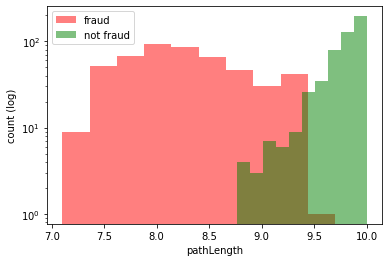

In [20]:
plot_relationship(norm=norm_pL,abnorm=fraud_pL,feature_name="pathLength")

### Appears that fraud cases do have shorter pathLength than non fraud cases even though pathLength is not normalized by tree depth 

### Use more sophiscated Sklearn Isolation forest 

### the parameters are from trial and error 

In [21]:
contam=training.Class.value_counts(normalize=True).loc[1] 
iFor = IsolationForest(n_estimators=120, max_samples=0.8, contamination=contam*1.5,max_features=1.0, 
                        bootstrap=False,random_state=42)

### Isolation Forest is supposed to be insensitive to outliers in the training dataset and we shall see if we get same outcome with normal vs data with fraud observations 

In [23]:
iForModel = iFor.fit(training.drop("Class",axis=1))

In [24]:
iForModel_norm = iFor.fit(norm.drop("Class",axis=1))

In [25]:
predicted_results = iForModel.predict(test_data)

In [26]:
predicted_results_norm = iForModel_norm.predict(test_data)

In [27]:
pred_score = iForModel.decision_function(test_data)

In [28]:
pred_score_norm = iForModel_norm.decision_function(test_data)

In [29]:
pd.DataFrame(pred_score).describe()

,0
count,56962.000000
mean,0.141762
std,0.022509
min,-0.306073
25%,0.137075
50%,0.146948
75%,0.153095
max,0.163801


In [30]:
pd.DataFrame(pred_score_norm).describe()

,0
count,56962.000000
mean,0.141762
std,0.022509
min,-0.306073
25%,0.137075
50%,0.146948
75%,0.153095
max,0.163801


In [42]:
model_results(label,-pred_score,0.06)  # negative score in sklearn version means abnormal 

[[56803    69]
 [   39    51]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.42      0.57      0.49        90

    accuracy                           1.00     56962
   macro avg       0.71      0.78      0.74     56962
weighted avg       1.00      1.00      1.00     56962



In [43]:
model_results(label,-pred_score_norm,0.06) # pred score is slightly adjusted 

[[56803    69]
 [   39    51]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.42      0.57      0.49        90

    accuracy                           1.00     56962
   macro avg       0.71      0.78      0.74     56962
weighted avg       1.00      1.00      1.00     56962



### Didn't appear to have a difference if train on all normal or contaminated samples. 

* Again proves that Isolation forest is not sensitive to outlier the same way as OneClassSVM

### Try gridSearchCV and create pseudo label to see if the outcome of grid search matches with orthognol tuning
  ### metrics are not the best for tuning since the class is very imbalanced 

In [44]:
parameters = {
              "n_estimators":[80,120],
              "max_samples":[0.5,0.8],
              "contamination":[contam*1.5, contam*2.0]
}

CV = GridSearchCV(IsolationForest(max_features=1.0,
                  bootstrap=False),
                  parameters,
                  scoring="f1_micro",
                  n_jobs=20,
                  verbose=1
                 )

### make sure y_true matches -1 for abnormal and 1 for normal 

In [45]:
y_true = training.Class
y_true[training.Class==0]=1
y_true[training.Class==1]=-1 

In [46]:
cvResults = CV.fit(training.drop("Class",axis=1),y_true)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  40 | elapsed:  2.6min finished


In [47]:
cvResults.best_params_

{'contamination': 0.0035287146963944786,
 'max_samples': 0.8,
 'n_estimators': 120}

In [48]:
cvResults.best_score_

0.0036691610524698806

In [49]:
best_model = cvResults.best_estimator_

In [50]:
predicted_results = best_model.predict(test_data)

In [51]:
best_pred_score = best_model.decision_function(test_data)

In [52]:
pd.DataFrame(best_pred_score).describe()

,0
count,56962.000000
mean,0.133654
std,0.020687
min,-0.321147
25%,0.128900
50%,0.138565
75%,0.144588
max,0.153462


In [55]:
model_results(label,-best_pred_score,0.06)

[[56816    56]
 [   57    33]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.37      0.37      0.37        90

    accuracy                           1.00     56962
   macro avg       0.68      0.68      0.68     56962
weighted avg       1.00      1.00      1.00     56962



### It appears that orthogonal tuning might have slight advantage